<a href="https://colab.research.google.com/github/KKAARRIIMM15/Generative-Adversarial-Network-GAN-/blob/main/Generative_Adversarial_Network_(GAN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## the Author Email is **karimeldeeb2001@gmail.com**
## the Author what's up number is **+201555604511**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL

# **This Cell is for**

 1- loading image and serialize it in pkl file to use it again direct with out loading and wasting time every time i run the project

 2- reshaping the image to the same width and same height dimension --> (112, 112) to be easy in plotting using matplotlib

In [ ]:

from PIL import Image
import numpy as np

all_Images = []  # this array will carry all Images of the dataSet
imgNO = "000001"
path = "drive//MyDrive//celeba_Folder//img_align_celeba"
path_template = "{:06d}"  # this is the template string for the path with six digits

for i in range(10001):   # i load only the firset 10000 Image to be suitable for memory

    image = Image.open( path + "\\" + imgNO + ".jpg" )
    new_size = (112, 112)  # Width, Height
    image = image.resize(new_size)  # i reshape it to be suitable for plotting
    image = ( np.array(image) / 255 )     # Normalize between 0 to 1

    all_Images.append(image)

    path_number = int(imgNO) + 1
    imgNO = path_template.format(path_number)



# loading the Images every time i run the project it waste a lot of time
# this why i serialized the images in pickle file to read it in a few seconds once i run the project
import pickle
serialized_object = pickle.dumps( all_Images )
with open('D:\\T5\\Serialized_Data.pkl', 'wb') as file:
    file.write(serialized_object)

In [ ]:
import pickle
with open('drive//MyDrive//celeba_Folder//Serialized_Data.pkl', 'rb') as file:
    # Load the pickled object from the file
    all_Images = pickle.load(file)

# I build a generator model using conv2d Transpose that take input of size 8 which is randomly distributed ( from 0 to 9 ) as noise and upSample it to  ( 112 , 112 , 3 )
In the last layer I use   -->  **model.add(layers.Conv2DTranspose(3, (5, 5), strides=(4, 4), padding='same', use_bias=False, activation='sigmoid'))**
To have an output of 3 channels with range ( from 0 to 1 )  because when I normalized the data I divide by 255 so the input to the discriminator was from 0 to 1 this is why I implement the generator using sigmoid to have an output with in the range the discriminator accept


In [ ]:

from tensorflow.keras import layers, models

def make_generator_model():
    latent_dim = 8
    model = models.Sequential()
    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.Conv2DTranspose(228, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(364, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(4, 4), padding='same', use_bias=False, activation='sigmoid'))
    # Final output shape: (112, 112, 3)
    return model


generator = make_generator_model()
generator.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             100352    
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 228)      1459200   
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 228)      9

**I build a Discriminator than take an image(Fake or Real) and perform Convolution Operation and the flatten the activation map then fed it to fully connected layer**

In [ ]:
import numpy as np

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(364, (5, 5), strides=(2, 2), padding='same', input_shape=[112, 112, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(228, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()


# **This Cell is for plotting only**

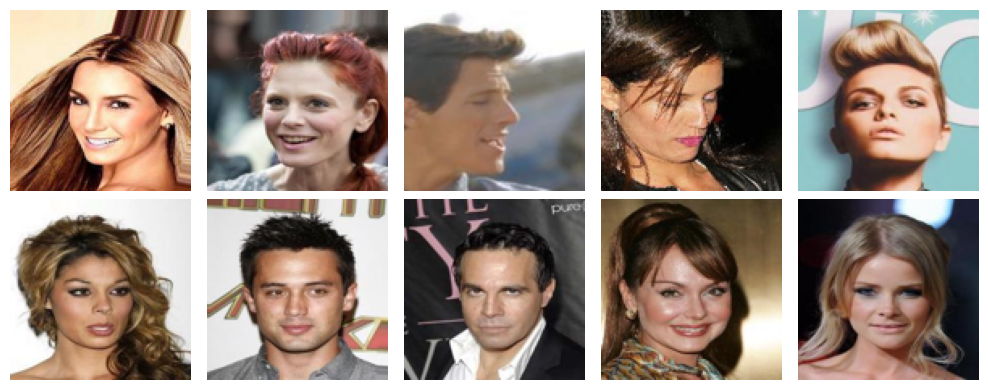

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

image_array = all_Images[:10]
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
axes = axes.ravel()

for i in range(len(image_array)):
    axes[i].imshow(image_array[i])
    axes[i].axis('off')


plt.tight_layout()
plt.show()


* **i use BinaryCrossentropy because i have only two category(Fake = 0 , real =1)**

* **tf.ones_like(real_output) --> create a vector of the same real_output size in which all index has value of One**

* **tf.zeros_like(fake_output) --> create a vector of the same fake_output size in which all index has value of Zero**

In [ ]:
def discriminator_loss(real_output, fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) # i use BinaryCrossentropy because i have only two category(Fake = 0 , real = 1)

  # tf.ones_like(real_output) --> create a vector of the same real_output size in which all index has value of One
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) # calculate how far is the real output to 1
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  # calculate how far is the fake_output to 0
    total_loss = real_loss + fake_loss
    return total_loss, real_loss, fake_loss



def generator_loss(fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)   # calculate how far is the fake_output to 1
    return loss


**i create two optimizer.**

**one for genrator and one for discrimnator**

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
seed = tf.random.normal([10, 8]) # i genrated 10 image to plot them after every epoch to see the progress

In [ ]:

@tf.function
def train_step(images):
    noise = tf.random.normal([10, 8])  # create 10 noise image

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True) # genrate 10 image to fed them to discrminator

      real_output = discriminator(images, training=True)  # train the discriminator with a batch of real image firest

      fake_output = discriminator(generated_images, training=True) # i fed the generated_images to Discriminator to take the output and calculate the loss
                                                              # because the Genrator weights is updated using the gradient obtained from discriminator feedback

      gen_loss = generator_loss(fake_output)
      disc_loss, real_loss, fake_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss, real_loss, fake_loss

In [ ]:
def train(dataset, epochs):
  gen_hist = []
  disc_hist = []
  disc_real_hist = []
  disc_fake_hist = []

  batches = np.array_split(dataset, 200)  # i saperate the dataset to 200 batch


  for epoch in range(epochs):
    i = 0
    while( i < len(batches) ):
      g_loss, d_loss, d_real_loss, d_fake_loss = train_step( batches[i] )
      g_loss = g_loss.numpy()
      d_loss = d_loss.numpy()
      d_real_loss = d_real_loss.numpy()
      d_fake_loss = d_fake_loss.numpy()
      gen_hist.append(g_loss)
      disc_hist.append(d_loss)
      disc_real_hist.append(d_real_loss)
      disc_fake_hist.append(d_fake_loss)
      i = i + 1

    if( epoch % 10 == 0): # there is no big diffrence between images being genrated by the generator every epoch so i plot them every 10 epochs to see the progress
      print(" \n \n Epoch: " + str( epoch ) )
      print("G_loss:", g_loss, "D_loss:", d_real_loss, d_fake_loss, d_loss)
      generate_and_save_images(generator,
                            epochs,
                            seed)
      plot_history(disc_real_hist, disc_fake_hist, disc_hist, gen_hist)


    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)





In [ ]:
def generate_and_save_images(model, epoch, test_input):

  predictions = model(test_input, training=False)
  image_array = predictions

  fig, axes = plt.subplots(2, 5, figsize=(10, 4))
  axes = axes.ravel()


  for i in range(len(image_array)):
      axes[i].imshow(image_array[i])
      axes[i].axis('off')

  plt.tight_layout()
  plt.show()



def plot_history(d1_hist, d2_hist, d_hist, g_hist):
  # plot loss
  plt.plot(d1_hist, label='d-real')
  plt.plot(d2_hist, label='d-fake')
  plt.plot(d_hist, label='d-total')
  plt.plot(g_hist, label='gen')
  plt.legend()
  # save plot to file
  plt.savefig('plot_loss.png')
  plt.show()
  plt.close()

 
 
 Epoch: 0
G_loss: 1.5348372 D_loss: 0.5999916 0.27214462 0.87213624


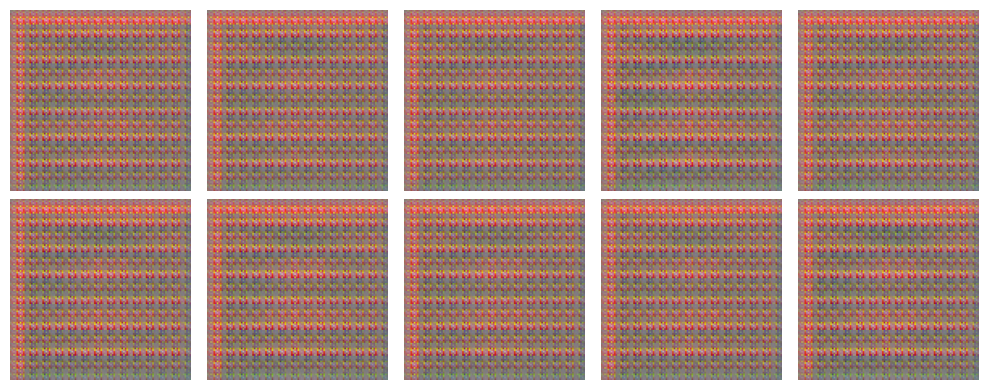

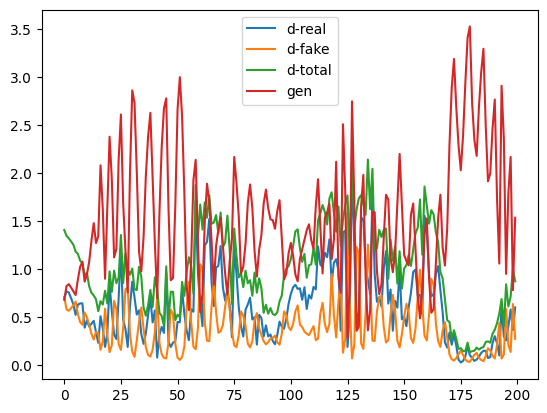

 
 
 Epoch: 10
G_loss: 1.652092 D_loss: 0.34499577 0.33342582 0.6784216


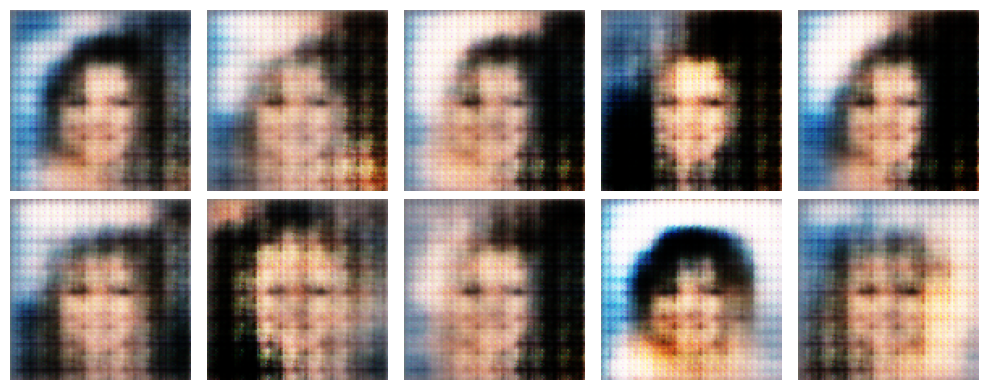

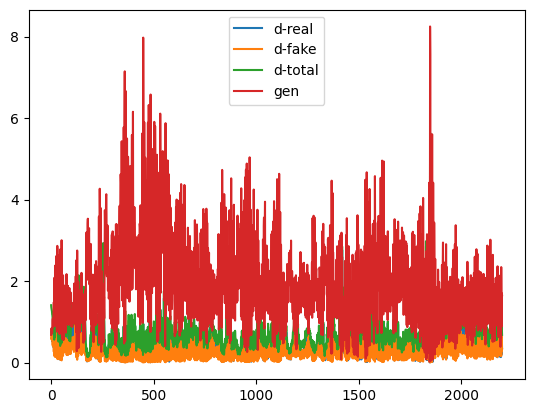

 
 
 Epoch: 20
G_loss: 1.1585596 D_loss: 0.32227096 0.39515716 0.7174281


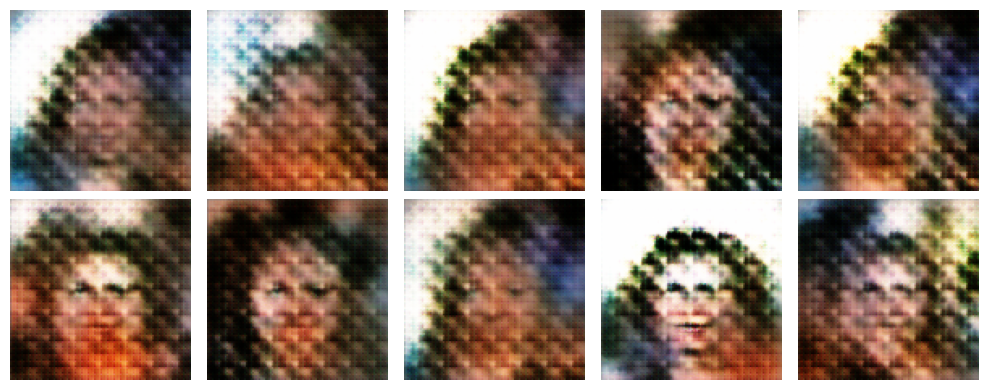

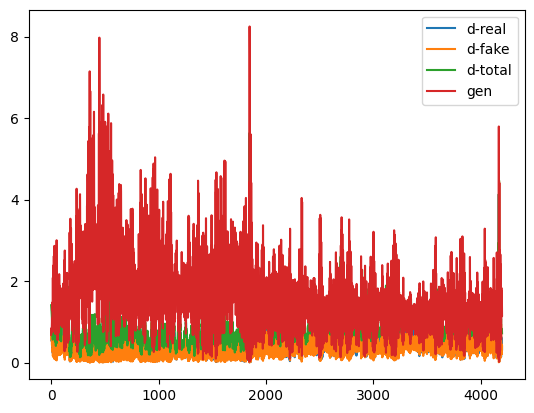

 
 
 Epoch: 30
G_loss: 1.1980699 D_loss: 0.25712976 0.44313216 0.70026195


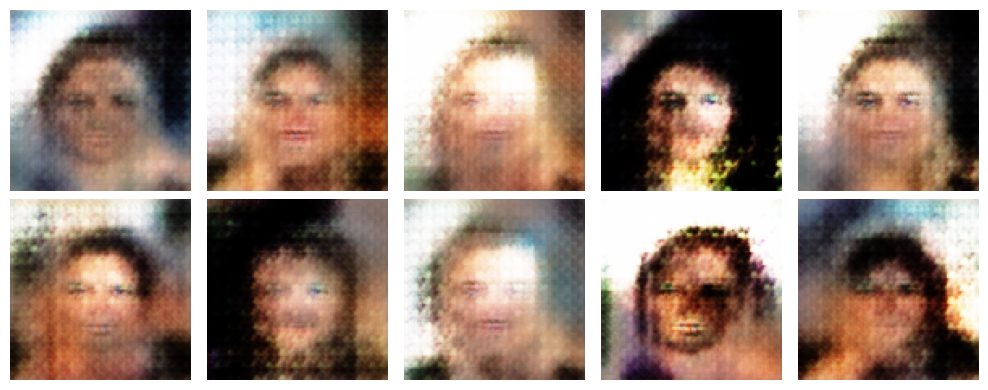

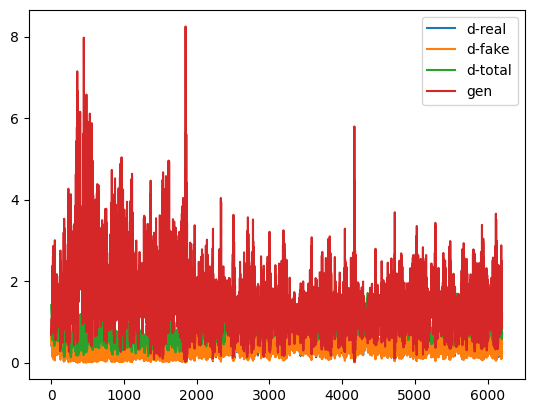

 
 
 Epoch: 40
G_loss: 1.5368325 D_loss: 0.4170944 0.359938 0.7770324


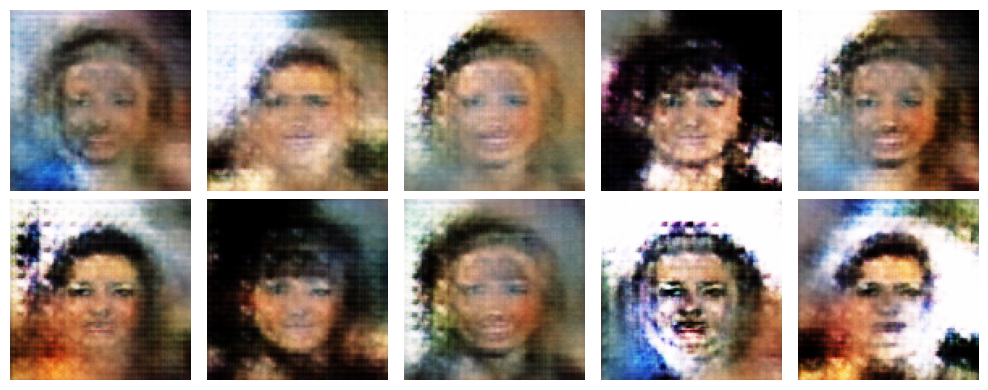

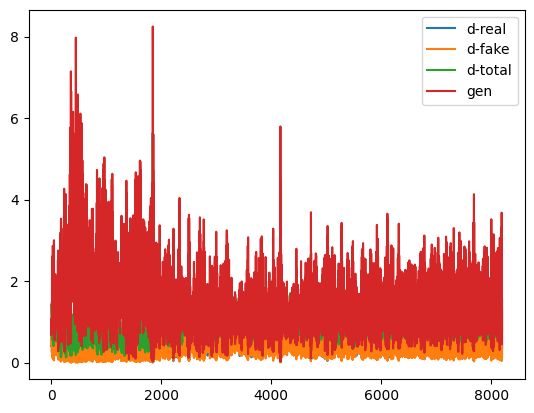

In [ ]:
train( all_Images , 50)